## Hipótesis 5:

#### "¿Qué cantidad de placas solares fotovoltaicas se necesitarían instalar para abastecer el consumo eléctrico de los hogares de Castilla-La Mancha en el año 2028?"

Esta hipótesis es interesante para conocer cuál es el verdadero potencial y la rentabilidad de uno de los dispositivos de aprovechamiento de energía renovables más comunes y utilizados actualmente, las placas solares fotovoltaicas.

### Preparación del entorno

In [32]:
import pandas as pd
import os
import math
import numpy as np
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Preparación de Datos

Aquí definimos la ruta a los archivos GOLD y cargamos data_card_5_df.csv

In [33]:
GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")
data_card_5_df = pd.read_csv(os.path.join(GOLD_DATA_PATH, "data_card_5_df.csv"), sep=";", encoding="latin1")

Eliminamos la columna Potencia MWh ya que no la necesitamos hasta el final 

In [34]:
df = data_card_5_df.drop(columns=['Potencia MWh'])

Transformamos el DataFrame a un formato largo donde cada fila representa una observación de consumo anual por provincia. Luego, aplicamos one-hot encoding a la columna Provincia para convertir las categorías en variables dummy.
Separamos las características (X) del objetivo (y). Escalamos las características numéricas y dividimos los datos en conjuntos de entrenamiento y prueba.

In [35]:
df_modelo = df.melt(
    id_vars=['Provincia'],
    var_name='Año',
    value_name='Consumo'
)
df_modelo['Año'] = df_modelo['Año'].astype('int64')
df_modelo_encoded = pd.get_dummies(df_modelo, columns=['Provincia'])

X = df_modelo_encoded.drop('Consumo', axis=1)
y = df_modelo_encoded['Consumo']
scaler = StandardScaler()
columnas_numericas = ['Año']
X[columnas_numericas] = scaler.fit_transform(X[columnas_numericas])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

## Función para evaluar los diferentes modelos probados

Esta función entrena el modelo, evalúa su rendimiento usando validación cruzada y predice el consumo para el año 2028. Calcula el error cuadrático medio (MSE) y el coeficiente de determinación (R2) para evaluar la precisión del modelo. También utilizamos R2 para hacer un comparación entre los valores de entrenamiento y los de prueba y ver si existe o no overfitting.

In [36]:
def evaluar_modelo(modelo):
    modelo.fit(X_train, y_train)
    
    r2_train = r2_score(y_train, modelo.predict(X_train))
    r2_test = r2_score(y_test, modelo.predict(X_test))
    
    mse_scores = -cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='r2')

    predicciones_2028 = pd.Series(index=df['Provincia'])

    for provincia in df['Provincia']:
        punto_2028 = X.iloc[-1:].copy()
        punto_2028['Año'] = 2028
        for col in [c for c in X.columns if c.startswith('Provincia_')]:
            punto_2028[col] = 0
        punto_2028[f'Provincia_{provincia}'] = 1
        punto_2028[columnas_numericas] = scaler.transform(punto_2028[columnas_numericas])
        prediccion_2028 = modelo.predict(punto_2028)[0]
        predicciones_2028[provincia] = prediccion_2028

    resultados = {
            'predicciones_2028': predicciones_2028,
            'R2_Train': r2_train,
            'R2_Test': r2_test,
            'MSE_Mean': mse_scores.mean(),
            'R2_Mean': r2_scores.mean(),
        }
    print("Predicciones de consumo para 2028:")
    for provincia, consumo in resultados['predicciones_2028'].items():
        print(f"{provincia}: {consumo:.2f} MWh")

    print("\nError Cuadrático Medio:", resultados['MSE_Mean'])
    print("R-squared Score:", resultados['R2_Mean'])
    

    
    print("\nAnálisis de Overfitting:")
    print(f"R2 Entrenamiento: {resultados['R2_Train']:.4f}")
    print(f"R2 Prueba: {resultados['R2_Test']:.4f}")
    
    dif_r2 = abs(resultados['R2_Train'] - resultados['R2_Test'])
    
    print("\nDiagnóstico de Overfitting:")
    if dif_r2 > 0.1:
        print("⚠️ Posible Overfitting detectado:")
        print(f"  - Diferencia en R2: {dif_r2:.4f}")
    else:
        print("No se detectan signos claros de Overfitting")
    
    return resultados


# Predicción con diferentes modelos

Procedemos a entrenar varios modelos con el fin de encontrar el que se adapte mejor a nuestros datos. Utilizaremos GridSearchCV para encontrar los mejores hiperparámetros de cada uno.

## 1. Predicción con Random Forest

### Descripción del Modelo
Random Forest es un algoritmo de ensamblaje que construye múltiples árboles de decisión y combina sus predicciones. Sus principales ventajas son:
- Robustez contra el overfitting
- Manejo de relaciones no lineales
- Capacidad de capturar interacciones complejas entre características

In [37]:
modelo = RandomForestRegressor(random_state=7)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth' : [10, 20, 30]
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
resultados_rf = evaluar_modelo(grid_search.best_estimator_)

Predicciones de consumo para 2028:
Albacete: 465510.90 MWh
Ciudad Real: 661151.93 MWh
Cuenca: 213587.15 MWh
Guadalajara: 335382.51 MWh
Toledo: 1061176.96 MWh

Error Cuadrático Medio: 1750544220.5276618
R-squared Score: 0.9821109431660228

Análisis de Overfitting:
R2 Entrenamiento: 0.9988
R2 Prueba: 0.9972

Diagnóstico de Overfitting:
No se detectan signos claros de Overfitting


## 2. Predicción con Gradient Boosting

### Descripción del Modelo
Gradient Boosting construye un modelo predictivo de forma secuencial, donde cada nuevo modelo corrige los errores del modelo anterior:
- Muy preciso en múltiples tipos de datos
- Maneja bien relaciones no lineales
- Menor riesgo de overfitting comparado con modelos individuales


In [38]:
modelo = GradientBoostingRegressor(random_state=7)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth' : [10, 20, 30]
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
resultados_gb = evaluar_modelo(grid_search.best_estimator_)

Predicciones de consumo para 2028:
Albacete: 459498.49 MWh
Ciudad Real: 646001.32 MWh
Cuenca: 212544.20 MWh
Guadalajara: 312116.39 MWh
Toledo: 1057291.93 MWh

Error Cuadrático Medio: 1985652036.0232117
R-squared Score: 0.9799707103742087

Análisis de Overfitting:
R2 Entrenamiento: 1.0000
R2 Prueba: 0.9966

Diagnóstico de Overfitting:
No se detectan signos claros de Overfitting


## 3. Predicción con Regresión Polinómica

### Descripción del Modelo
La Regresión Polinómica permite capturar relaciones no lineales mediante transformación de características:
- Útil cuando la relación entre variables no es lineal
- Grados polinómicos diferentes capturan distintos tipos de no linealidad
- Riesgo de overfitting con grados muy altos


In [39]:
modelo = Pipeline([
    ('poly', PolynomialFeatures()),
    ('lr', LinearRegression())
])
param_grid = {
    'poly__degree': [2, 3, 4]
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
resultados_rp = evaluar_modelo(grid_search.best_estimator_)

Predicciones de consumo para 2028:
Albacete: 262796.45 MWh
Ciudad Real: 492322.79 MWh
Cuenca: 35332.64 MWh
Guadalajara: 158910.89 MWh
Toledo: 913691.11 MWh

Error Cuadrático Medio: 2430372693.373352
R-squared Score: 0.9708961721723546

Análisis de Overfitting:
R2 Entrenamiento: 0.9934
R2 Prueba: 0.9923

Diagnóstico de Overfitting:
No se detectan signos claros de Overfitting


## 4. Predicción con Árbol de Decisión

### Descripción del Modelo
Los Árboles de Decisión dividen recursivamente los datos basándose en criterios de división:
- Muy interpretables
- Capturan relaciones no lineales
- Tienden a sobreajustarse si no se controla la profundidad


In [40]:
modelo = DecisionTreeRegressor()
param_grid = {
    'max_depth' : [10, 20, 30]
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
resultados_dt = evaluar_modelo(grid_search.best_estimator_)

Predicciones de consumo para 2028:
Albacete: 459494.65 MWh
Ciudad Real: 646002.43 MWh
Cuenca: 212533.80 MWh
Guadalajara: 312108.64 MWh
Toledo: 1057303.97 MWh

Error Cuadrático Medio: 1985791294.1620183
R-squared Score: 0.9799696951852935

Análisis de Overfitting:
R2 Entrenamiento: 1.0000
R2 Prueba: 0.9966

Diagnóstico de Overfitting:
No se detectan signos claros de Overfitting


## Elección del mejor modelo para nuestra hipótesis

Creamos un gráfico para comparar las predicciones de consumo para 2028 de los diferentes modelos. Esto nos ayuda a visualizar las diferencias entre los modelos y seleccionar el mejor. Además tenemos los valores del error cuadrático medio y el coeficiente de determinación en los resultados de arriba.

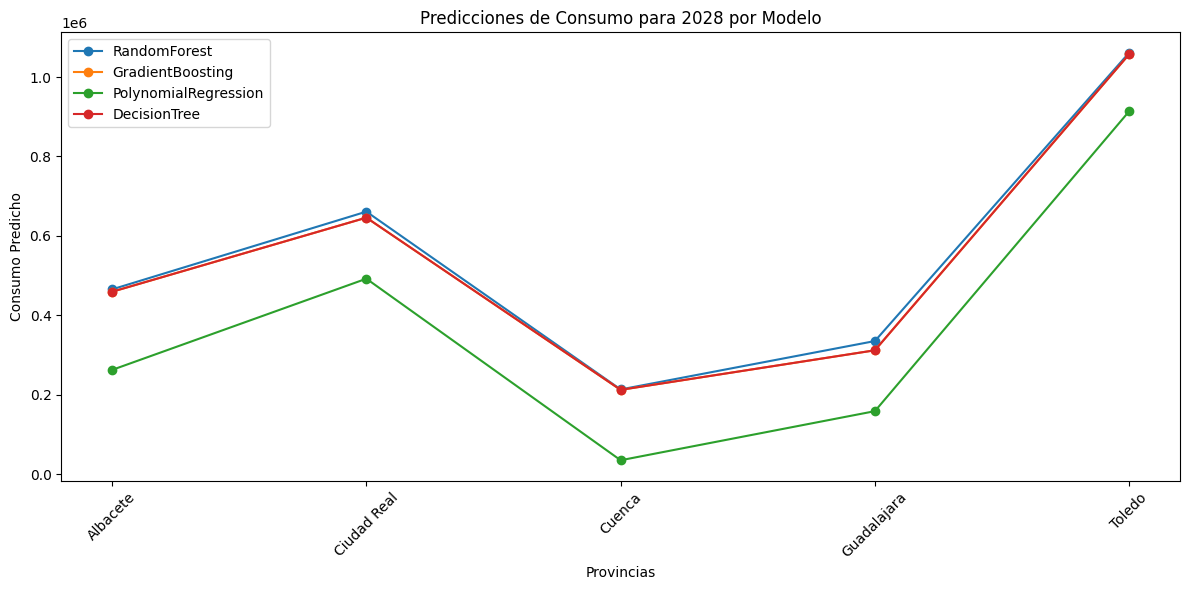

In [41]:
predicciones_2028 = {}
predicciones_2028['RandomForest'] = resultados_rf['predicciones_2028']
predicciones_2028['GradientBoosting'] = resultados_gb['predicciones_2028']
predicciones_2028['PolynomialRegression'] = resultados_rp['predicciones_2028']
predicciones_2028['DecisionTree'] = resultados_dt['predicciones_2028']

plt.figure(figsize=(12, 6))
for nombre, predicciones in predicciones_2028.items():
    plt.plot(predicciones.index, predicciones.values, label=nombre, marker='o')

plt.title('Predicciones de Consumo para 2028 por Modelo')
plt.xlabel('Provincias')
plt.ylabel('Consumo Predicho')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Podemos observar que la regresión polinómica es la que más difiere y eso va de la mano con el peor valor de R2. Luego tenemos muy similares los otros modelos pero hay uno que sobresale a los demás, el RandomForest tiene el menor cuadrado de las medias de los errores y el coeficiente de determinación R2 más cercano a 1.

## Predicción del consumo en el año 2028

Usando el mejor modelo, RandomForest, creamos un gráfico que muestra el consumo histórico de energía por provincia y las predicciones para 2028

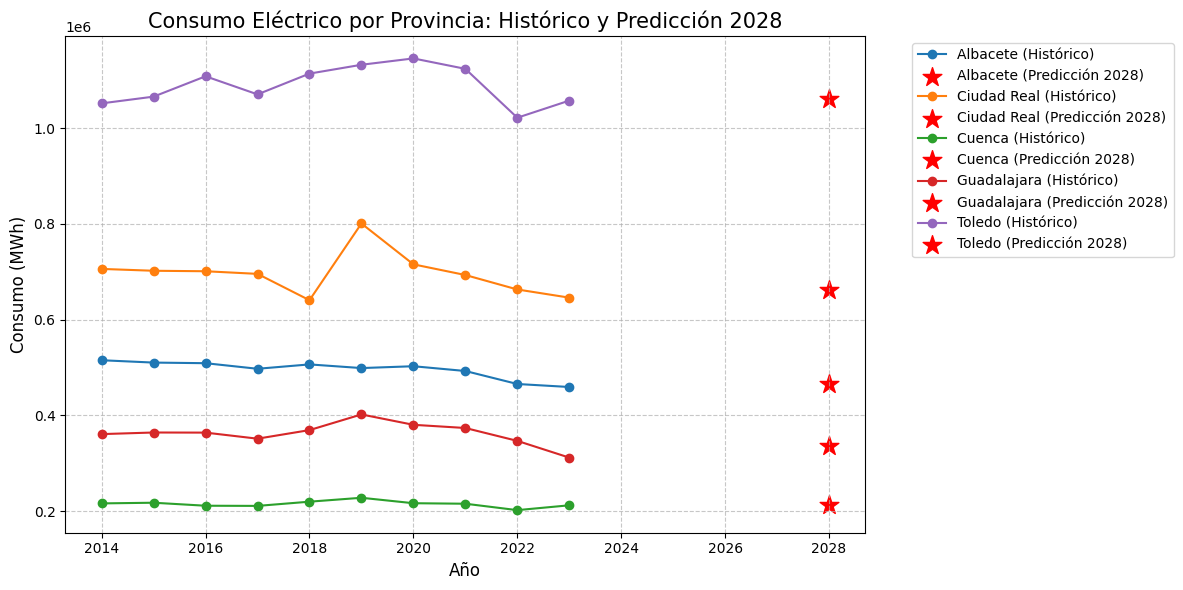

In [42]:
datos = df
predicciones_2028 = resultados_rf['predicciones_2028']
plt.figure(figsize=(12, 6))

for provincia in datos['Provincia']:
    datos_provincia = datos[datos['Provincia'] == provincia]
    años = [int(col) for col in datos.columns[1:]]
    consumo = datos_provincia.iloc[0, 1:].tolist()
    plt.plot(años, consumo, marker='o', label=f'{provincia} (Histórico)')
    
    plt.scatter(2028, predicciones_2028[provincia], marker='*', 
                color='red', s=200, 
                label=f'{provincia} (Predicción 2028)')

plt.title('Consumo Eléctrico por Provincia: Histórico y Predicción 2028', fontsize=15)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Consumo (MWh)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Por último, calculamos el número de placas solares necesarias para satisfacer el consumo energético predicho para 2028. Asumimos que cada placa tiene un rendimiento del 20% y mostramos el total de placas necesarias

In [43]:
potencia_placas = data_card_5_df['Potencia MWh']
potencia_placas.index = data_card_5_df['Provincia']

prediccion_placas = (predicciones_2028 / potencia_placas) / 0.2

print("Tomando como datos placas de 1m^2 y teniendo en cuenta que suelen tener un rendimiento del 20%")
print("Predicciones de placas para 2028:")
for provincia, placas in prediccion_placas.items():
    print(f"{provincia}: {math.ceil(placas)} placas")
    
print("Total de placas necesarias en 2028 en Castilla La Mancha:", math.ceil(sum(prediccion_placas)))
    

Tomando como datos placas de 1m^2 y teniendo en cuenta que suelen tener un rendimiento del 20%
Predicciones de placas para 2028:
Albacete: 1420673 placas
Ciudad Real: 2035302 placas
Cuenca: 664122 placas
Guadalajara: 1076719 placas
Toledo: 3260288 placas
Total de placas necesarias en 2028 en Castilla La Mancha: 8457102
